## Definições e Imports

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import make_scorer, mean_squared_error
from math import sqrt

# Definir random state e métrica
seed = 1
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

scorer = make_scorer(rmse, greater_is_better=False)
cv = TimeSeriesSplit(n_splits=5)

# Novo conjunto de algoritmos
algorithms = {
    'Decision Tree': GridSearchCV(
        Pipeline([('scaler', RobustScaler()), ('tree', DecisionTreeRegressor(random_state=seed))]),
        param_grid={
            'tree__max_depth': [10, 20, 30],
            'tree__criterion': ['squared_error', 'friedman_mse'],
        },
        scoring=scorer,
        cv=cv,
    ),
    'KNN': GridSearchCV(
        Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor())]),
        param_grid={
            'knn__n_neighbors': [3, 5, 7],
            'knn__weights': ['uniform', 'distance'],
        },
        scoring=scorer,
        cv=cv,
    ),
    'MLP': GridSearchCV(
        Pipeline([('scaler', StandardScaler()), ('mlp', MLPRegressor(random_state=seed, max_iter=500))]),
        param_grid={
            'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'mlp__activation': ['relu', 'tanh', 'logistic'],
        },
        scoring=scorer,
        cv=cv,
    ),
    'Random Forest': GridSearchCV(
        Pipeline([
            ('scaler', StandardScaler()),
            ('rf', RandomForestRegressor(random_state=seed))]),
        param_grid={
            'rf__n_estimators': [50, 100],
            'rf__max_depth': [10, 20],
        },
        scoring=scorer,
        cv=cv,
    ),
    'AdaBoost': GridSearchCV(
        Pipeline([('scaler', StandardScaler()), ('ada', AdaBoostRegressor(random_state=seed))]),
        param_grid={
            'ada__n_estimators': [50, 100, 200],
            'ada__learning_rate': [0.01, 0.1, 1],
        },
        scoring=scorer,
        cv=cv,
    ),
    'Gradient Boosting': GridSearchCV(
        Pipeline([('scaler', StandardScaler()), ('gb', GradientBoostingRegressor(random_state=seed))]),
        param_grid={
            'gb__n_estimators': [50, 100, 200],
            'gb__learning_rate': [0.01, 0.1, 0.2],
            'gb__max_depth': [3, 5, 7],
        },
        scoring=scorer,
        cv=cv,
    ),
}

In [17]:
# Definindo o ticker e datas
acao = 'ABEV3.SA' # MGLU3.SA, ITUB3.SA, VALE3.SA, WEGE3.SA, PETR4.SA, BBDC4.SA, BBAS3.SA, ABEV3.SA, ABEV3.SA
ini_train = '2020-12-31'
fim_train = '2024-09-10'
fim_test = '2024-10-10'

itau = yf.Ticker(acao)
train = itau.history(start=ini_train, end=fim_train, interval='1d')['Close']
test = itau.history(start=fim_train, end=fim_test, interval='1d')['Close']

# Log-retorno para estabilizar a série
train_log_return = np.log(train / train.shift(1)).dropna()
test_log_return = np.log(test / test.shift(1)).dropna()
initial_value = test.iloc[0]  # Valor inicial para conversão

In [18]:
# Executar cross-validation e coletar as melhores métricas
results = []
for algo_name, algo in algorithms.items():
    algo.fit(train_log_return.values.reshape(-1, 1), train_log_return)
    best_rmse = abs(algo.best_score_)
    results.append({
        "Algorithm": algo_name,
        "Best RMSE": best_rmse
    })
    print(f"{algo_name}: Best RMSE = {best_rmse:.4f}")

Decision Tree: Best RMSE = 0.0007
KNN: Best RMSE = 0.0008
MLP: Best RMSE = 0.0093
Random Forest: Best RMSE = 0.0009
AdaBoost: Best RMSE = 0.0013
Gradient Boosting: Best RMSE = 0.0007


In [19]:
# Tabela de comparação dos resultados
results_df = pd.DataFrame(results)
print("\nTabela de Resultados Comparativos:")
print(results_df)


Tabela de Resultados Comparativos:
           Algorithm  Best RMSE
0      Decision Tree   0.000664
1                KNN   0.000806
2                MLP   0.009283
3      Random Forest   0.000898
4           AdaBoost   0.001270
5  Gradient Boosting   0.000664


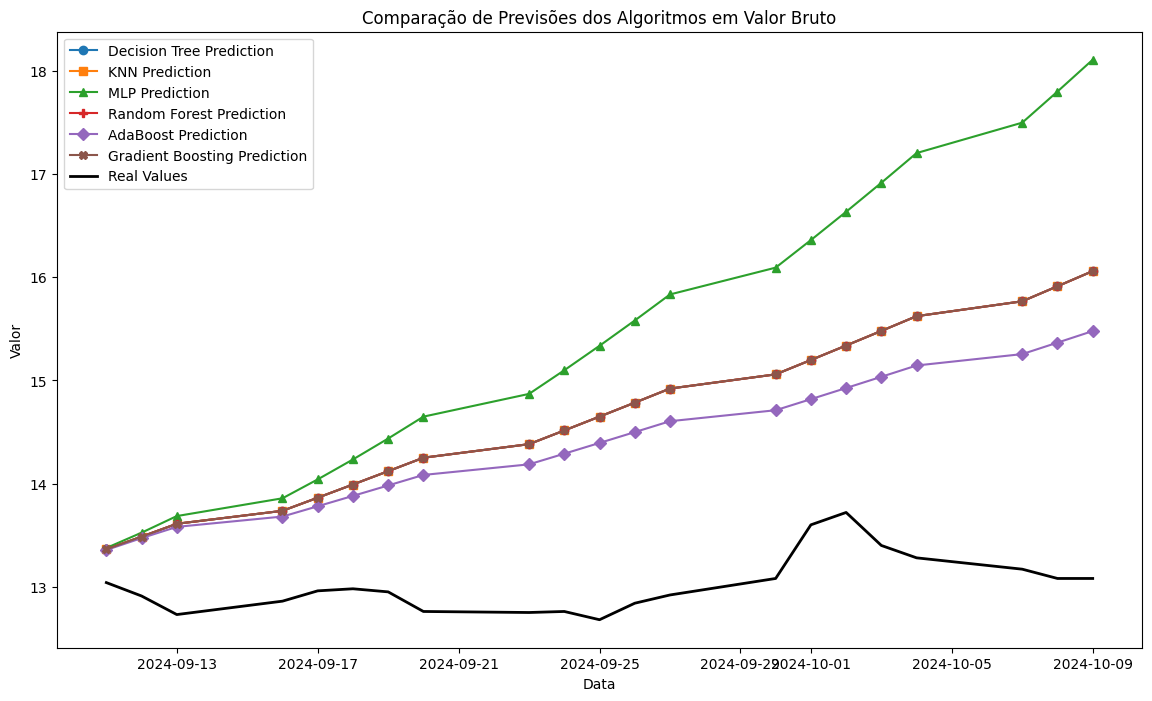

In [20]:
# Função para previsões recursivas sem data leakage
def recursive_forecast(algo, train_log_return, days_to_predict, initial_value):
    history = list(train_log_return)  # Inicia o histórico com dados de treino
    predictions = []

    for _ in range(days_to_predict):
        # Faz a previsão para o próximo ponto
        pred_log_return = algo.predict(np.array([history[-1]]).reshape(1, -1))[0]
        
        # Adiciona a previsão ao histórico para a próxima iteração
        predictions.append(pred_log_return)
        history.append(pred_log_return)

    # Converte previsões de log-retorno para valores brutos
    cumulative_predictions = np.cumsum(predictions)
    predicted_values = initial_value * np.exp(cumulative_predictions)
    return predicted_values

# Executa previsões recursivas para cada modelo
predictions_converted = {}
days_to_predict = len(test_log_return)
for algo_name, algo in algorithms.items():
    predictions_converted[algo_name] = recursive_forecast(algo, train_log_return, days_to_predict, initial_value)

# Converte o log-retorno real para valor bruto para comparação
cumulative_real_log_return = np.cumsum(test_log_return)
real_values = initial_value * np.exp(cumulative_real_log_return)

# Gráfico comparativo de previsões em valores brutos
plt.figure(figsize=(14, 8))
markers = ['o', 's', '^', 'P', 'D', 'X', 'H']  # Diferentes marcadores para cada algoritmo

for i, (algo_name, preds) in enumerate(predictions_converted.items()):
    plt.plot(test_log_return.index, preds, label=f"{algo_name} Prediction", marker=markers[i % len(markers)])

plt.plot(test_log_return.index, real_values, label="Real Values", color='black', linewidth=2)
plt.title("Comparação de Previsões dos Algoritmos em Valor Bruto")
plt.xlabel("Data")
plt.ylabel("Valor")
plt.legend()
plt.show()